# Twitter Sentiment Analyzer using Recurrent Neural Networks

Ioannis Maliaras - 1115021500084  
31-12-2020

**Note: The first part of this notebook, a.k.a. the data cleaning, stemming and lemmatization is directly copied from the first assignment's notebook. The dataset is the same, therefore we use the same data cleaning techniques, since they proved good enough**

## Startup - Imports - Dataset

Let's import all our base dependencies and read the dataset file. We will import all other dependencies in their respective blocks.

In [146]:
!pip install PyDrive texttable nltk
!pip install torchtext
# !pip install torch===1.7.0 torchvision===0.8.1 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import numpy as np
import pandas as pd
import math
import torch
import scipy
import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from torch import LongTensor, FloatTensor
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [147]:
file = drive.CreateFile({'id': "1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79"})
file.GetContentFile('SentimentTweets.csv')
documents = pd.read_csv('SentimentTweets.csv')

Firstly, let's explain some things about the given dataset. This dataset contains a large amount of tweets and their sentiments. Any other information (attributes) do not matter for us. We only care about the actual text, and the target sentiment. We will create new features on our own derived from the text (using Tfidf Vectorization as you will see below).

In [148]:
attributes = ['text', 'target']
documents = documents[attributes]

Moreover, it is important to note that the values in the 'target' column that represent the sentiment are of type [0, 4] where 0 represents the negative sentiment and 4 the positive. There is no in-between neutral value (e.g. 2), as there might be in other datasets. This Sentiment Analyzer only predicts negative or positive sentiment.

## Data Cleanup

Let's continue with cleaning up the text data. We are going to:
1. Make the text lowercase  
> We find that there is no reason to keep any capitalization on the data. One could make the argument, that words with fully capital letters could make a difference to the sentiment interpretation of a sentence or text, but that fully uppercase word could be positive or negative regardless of the capitalization. Therefore, we make the whole text lowercase.
2. Remove any URLs, @user and # references
> Pretty straightforward, such words have no value to us in sentiment analysis.
4. Remove all punctuation
> As with uppercase text, one could make the argument that puncuation could have some meaning in a given text. But there is no value to that, if we can't know whether they are used in a positive or negative manner. For example, an exclamation point (!) could be used in either sentences, that have opposite sentiments:
> * This movie was awesome!
> * That restaurant was terrible!
5. Remove stopwords
6. Stem or Lemmatize
> Steps 5 and 6 are well-known successful techniques to clean up data.

Let's define that function.

In [149]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemming = PorterStemmer()

def preprocess_tweet(text):
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove Stop Words
    tokenized = word_tokenize(text)
    stopped = [word for word in tokenized if not word in stop_words]

    # clean = [stemming.stem(word) for word in tokenized]
    clean = [lemmatizer.lemmatize(word, pos='a') for word in stopped]

    return " ".join(clean)


Now this procedure will take a long time, considering the size of the dataset. In this particular assignment we have more than 1 million tweets. Therefore, we save the processed data in a file, and load them each time we want to reset our runtime.
Depending on whether the file exists, we run the preprocessing function or read form the file to get our final processed and clean data.

In [150]:
PROCESSED_FILENAME = 'processed_tweets.csv'
FINAL_FILENAME = 'final_tweets.csv'

from os import path

if (path.exists(PROCESSED_FILENAME)):
    tmp = pd.read_csv(PROCESSED_FILENAME, sep=',')
    documents['clean'] = tmp['clean']
else:
    documents['clean'] = documents['text'].apply(preprocess_tweet)
    # Save the data
    documents['clean'].to_csv(PROCESSED_FILENAME, sep=',')


documents.to_csv(FINAL_FILENAME, sep=',')

## Data Loading and Vocabulary

We will use `torchtext` to create and "serve" the dataset to our models. `torchtext` provides us with handy functions to do that. However, we will have to split our dataset to train, test and validation data beforehand and write them to specific files.

We create a `split_files` function that takes our initial processed dataframe, and splits it into files given a length. The length defines how long our dataset will be. This is helpful, because our dataset is too big to be of any convenience for testing and debugging.

In [151]:
from torchtext import data

TRAIN_FILENAME = 'train'
VALID_FILENAME = 'valid'
TEST_FILENAME = 'test'

def split_files(docs, length, test_size=0.1, valid_size=0.1):
    data = docs[:length]

    train_data, test_data = train_test_split(data, test_size=test_size, random_state=41, stratify=data['target'])
    train_data, valid_data = train_test_split(train_data, test_size=valid_size, random_state=42, stratify=train_data['target'])

    train_data.to_csv(f'{TRAIN_FILENAME}x{length}.csv', sep=',')
    valid_data.to_csv(f'{VALID_FILENAME}x{length}.csv', sep=',')
    test_data.to_csv(f'{TEST_FILENAME}x{length}.csv')


Naturally, we will also create the `load_files` function that loads files if they exist, given a specific length. We will also be removing empty lines using the `filter_pred` parameter.

In [152]:
def load_files(length, fields):
    return data.TabularDataset.splits(
        path = '',
        train=f'{TRAIN_FILENAME}x{length}.csv',
        validation=f'{VALID_FILENAME}x{length}.csv',
        test=f'{TEST_FILENAME}x{length}.csv',
        format = 'csv',
        fields = fields,
        skip_header = True,
        filter_pred=lambda x: x.clean[:] != []
    )


Time to load our data.

In [153]:
DATASET_LENGTH = -1

TEXT = data.Field(tokenize = 'spacy', include_lengths=True)
LABEL = data.LabelField(dtype = torch.float)
fields = [(None, None), (None, None), ('target', LABEL), ('clean', TEXT)]

split_files(documents, DATASET_LENGTH, test_size=0.05, valid_size=0.05)
train_data, valid_data, test_data = load_files(DATASET_LENGTH, fields)

We create the vocabulary using our text & pre trained word embeddings. For this experiment we will use the `torchtext` `glove.6B.100d` embeddings.

In [154]:
MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = 'glove.twitter.27B.50d',
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

Similarly to the previous assignment, we will need to pass our dataset for training using batches. We did a custom implementation last time, but using `torchtext` makes things a lot easier. Moreover, we are now using a GPU runtime & cuda, since it provides us with classes of speedup for our experiments.

We will use the `device` variable in many places.

In [155]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key=lambda x: len(x.clean),
    device = device
)

## Evaluation Mechanisms

We will define some basic classes and a consistent inheritable training, testing, scoring and plotting class. They will calculate training information, like elapsed time, learning curves, and also evaluation such as precision, accuracy, f1, recall and plot a ROC curve. It's also an easy way to generalize training, while simultaneously making our experiments a bit more concise and readable.

#### Learning Analyzer

This class will use return value of our `train` method for each of our models. It will take lists of losses per epoch for training and validation/test data and will provide methods to plot them in different ways.

In [156]:
class LearningAnalyzer:
    def __init__(self, train_loss, test_loss, epochs=50):
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epochs = epochs

    def training_loss(self, epochs=None):
        if not epochs:
            epochs = self.epochs
        
        plt.plot(range(epochs), self.train_loss, label="Training")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss to Epochs")
        plt.legend()
        plt.show()

    def learning_curves(self, epochs=None):
        if not epochs:
            epochs = self.epochs
        
        plt.plot(range(epochs), self.train_loss, label="Training")
        plt.plot(range(epochs), self.test_loss, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Learning Curves")
        plt.legend()
        plt.show()


#### ScoreKeeper

This class will be the return value of our `evaluate` method if parameterized. It will get the predicted (y_pred) and real (y) values of our test and calculate scores. Then it will provide methods for calculating metrics and plotting scores, roc curves and the such.

In [157]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import classification_report

class ScoreKeeper:
    def __init__(self, predicted, real, rounded):
        self.real = real
        self.predicted = predicted
        self.rounded = rounded

    def report(self):
        print(classification_report(self.real, self.rounded))

    def f1(self):
        return f1_score(real, rounded)
    
    def precision(self):
        return precision_score(real, rounded)

    def recall(self):
        return recall_score(real, rounded)

    def accuracy(self):
        return accuracy_score(real, rounded)

    def roc(self):
        return roc_curve(self.real, self.predicted)

    def plot_roc(self):
        fpr, tpr, thresholds = roc_curve(self.real, self.predicted)

        plt.plot(fpr, tpr, label='ROC')

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Roc Curve")
        plt.legend()
        plt.show()

For testing purposes, we copy the below 3 functions from various RNN projects (see Citations), which calculate model accuracy, as well as time taken for each epoch of training.

### Miscellaneous

In [158]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {params:,} trainable parameters')
    return params

In [159]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()

    acc = correct.sum() / len(correct)
    return acc

In [160]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

## Our Models

### Base Testing Class

We will create a simplte training & testing class that trains a evaluates a model returning learning analysis and scores if asked.

In [44]:
class TestRNN():
    def __init__(self, model, device):

        self.model = model.to(device)

        self.criterion = nn.BCEWithLogitsLoss().to(device)
        self.optimizer = optim.Adam(self.model.parameters())

    def train(self, iterator):
        epoch_loss = 0
        epoch_acc = 0

        self.model.train()

        for batch in iterator:
            self.optimizer.zero_grad()

            text, text_lengths = batch.clean

            preds = self.model(text, text_lengths).squeeze(1)
            loss = self.criterion(preds, batch.target)

            acc = binary_accuracy(preds, batch.target)

            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def evaluate(self, iterator, plot = False):
        epoch_loss = 0
        epoch_acc = 0

        self.model.eval()

        if plot:
            real = []
            predictions = []
            rounded_predictions = []

        with torch.no_grad():

            for batch in iterator:

                text, text_lengths = batch.clean

                preds = self.model(text, text_lengths).squeeze(1)

                loss = self.criterion(preds, batch.target)
                acc = binary_accuracy(preds, batch.target)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

                if plot:
                    real += batch.target.tolist()
                    predictions += torch.sigmoid(preds).tolist()
                    rounded_predictions += torch.round(torch.sigmoid(preds)).tolist()

        if plot:
            return epoch_loss / len(iterator), epoch_acc / len(iterator), ScoreKeeper(predictions, real, rounded_predictions)

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

### First Try (LSTM)

Now let's create our first RNN. This is heavily inspired by the RNNs shown in projects cited. It contains an Embedding Layer, inside which we will copy our pretrained embeddings. Next, is a single LSTM module and a Dropout Module.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        embedded = self.dropout(embedded)

        packed = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        packed_output, (hidden, cell) = self.rnn(packed)

        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1 ))

        return self.fc(hidden)


#### Parameterization

Now, after implementing the class we shall create an instance of it and specify its parameters. These parameters are the basis of our experiments, since we will be tweaking them a lot to reach to the best model that we can.

In [ ]:
EPOCHS = 10
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50 # This is the glove embeddings we have donwloaded
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
LEARNING_RATE = 1e-5
DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

The final step is to copy (replace) our pre-trained embeddings into our model embedding layer, and also initialize the pad and unk tokens to zero, since they seem to be initialized as a random number.

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.2413,  0.6175,  0.7313,  ...,  1.6931,  1.2796,  0.2829],
        [-0.3410,  1.4481,  0.3564,  ..., -0.5393,  1.0276, -0.1161],
        [ 0.0583,  1.3067,  0.0071,  ..., -0.4188,  0.4549, -0.5082],
        ...,
        [ 0.4156,  0.0547, -0.7844,  ...,  0.6150,  0.0126, -0.3223],
        [-1.4078,  0.1634, -0.3136,  ...,  0.1820, -1.2061,  0.1299],
        [-0.9243, -0.2683,  0.6521,  ...,  0.3083, -0.1077, -0.2120]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

#### Training & Testing

Time to test!

In [ ]:
best_valid_loss = float('inf')
Neural = TestRNN(model, device)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = Neural.train(train_iterator)
    valid_loss, valid_acc = Neural.evaluate(valid_iterator)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'first.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_losses += [train_loss]
    valid_losses += [valid_loss]

la = LearningAnalyzer(train_losses, valid_losses, EPOCHS)

Epoch: 01 | Epoch Time: 4m 33s
	Train Loss: 0.532 | Train Acc: 73.45%
	 Val. Loss: 0.461 |  Val. Acc: 78.23%
Epoch: 02 | Epoch Time: 4m 33s
	Train Loss: 0.491 | Train Acc: 76.57%
	 Val. Loss: 0.453 |  Val. Acc: 78.85%
Epoch: 03 | Epoch Time: 4m 33s
	Train Loss: 0.479 | Train Acc: 77.41%
	 Val. Loss: 0.455 |  Val. Acc: 78.98%
Epoch: 04 | Epoch Time: 4m 33s
	Train Loss: 0.472 | Train Acc: 77.79%
	 Val. Loss: 0.458 |  Val. Acc: 78.91%
Epoch: 05 | Epoch Time: 4m 33s
	Train Loss: 0.469 | Train Acc: 78.03%
	 Val. Loss: 0.454 |  Val. Acc: 79.09%
Epoch: 06 | Epoch Time: 4m 34s
	Train Loss: 0.466 | Train Acc: 78.26%
	 Val. Loss: 0.484 |  Val. Acc: 78.57%
Epoch: 07 | Epoch Time: 4m 33s
	Train Loss: 0.463 | Train Acc: 78.42%
	 Val. Loss: 0.481 |  Val. Acc: 78.21%
Epoch: 08 | Epoch Time: 4m 33s
	Train Loss: 0.462 | Train Acc: 78.50%
	 Val. Loss: 0.485 |  Val. Acc: 78.43%
Epoch: 09 | Epoch Time: 4m 33s
	Train Loss: 0.461 | Train Acc: 78.62%
	 Val. Loss: 0.472 |  Val. Acc: 78.52%
Epoch: 10 | Epoch T

We shall show some plots for our experiment. Firstly, we plot the learning curves. This will give us a good idea on whether our model is over-, or underfitting.

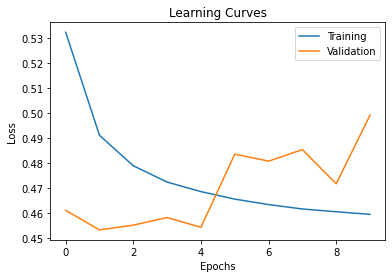

In [ ]:
la.learning_curves()

Lastly, we test our model using our test set. Using the `ScoreKeeper` class defined earlier, we print a classification report and the ROC curve.

Test Loss: 0.498 | Test Acc: 78.36%
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80     31900
         1.0       0.83      0.71      0.77     31826

    accuracy                           0.78     63726
   macro avg       0.79      0.78      0.78     63726
weighted avg       0.79      0.78      0.78     63726



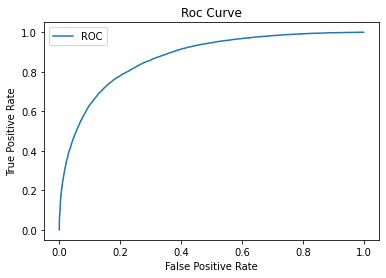

In [ ]:
test_loss, test_acc, sc = Neural.evaluate(test_iterator, plot = True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

sc.report()
sc.plot_roc()

#### Experiment Documentation

We document every experiment we did on hyperparameter tuning as well as its overall result. We use accuracy to evalute performance and conclude on the learning wellness by reading the learning curves.

Every result on the tables below has been found using the code above. Specifically, we run all code up to the #OurModels point, tweak the parameters on the Parameterization section and run the Training & Testing section, documenting the results as the last step.

We will start with a small dataset of 50k examples, to test the waters. 30 Epochs seems like a reasonable value given the time it takes for a deep recurrent neural network takes to train, so we will keep the epochs constant, unless we find prohibitively long training times.

##### 50k

| TRAIN SIZE | EPOCHS |  N_LAYERS | EMBEDDING_DIM | HIDDEN_DIM | BIDIRECTIONAL | LEARNING_RATE | DROPOUT | TIME PER EPOCH | FINAL TRAIN LOSS |ACCURACY | LEARNING CONCLUSION
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 50k | 30 | 2 | 50 | 32 | FALSE | 1e-3 | 0.01 | 3s | | **71%** | **Overfit** |
| 50k | 30 | 2 | 50 | 64 | FALSE | 1e-3 | 0.5 | 3s | 0.237 | **73%** | **Overfit** |
| 50k | 30 | 2 | 50 | 128 | FALSE | 1e-3 | 0.5 | 3s | 0.220 | **74%** | **Overfit** |
| 50k | 30 | 2 | 50 | 256 | FALSE | 1e-3 | 0.5 | 3s | 0.206 | **74%** | **Overfit** |
| 50k | 30 | 2 | 50 | 256 | TRUE | 1e-3 | 0.5 | 5s | 0.194 | **74%** | **Overfit** |
| 50k | 30 | 2 | 50 | 256 | TRUE | 1e-4 | 0.5 | 5s | 0.193 | **73%** | **Overfit** |
| 50k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.5 | 5s | 0.193 | **73%** | **Overfit** |
| 50k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.6 | 5s | 0.273 | **74%** | **Overfit** |
| 50k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.7 | 5s | 0.347 | **75%** | **Better Overfit** |
| 50k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.8 | 5s | 0.418 | **76%** | **OK Fit** |
| 50k | 30 | 3 | 50 | 256 | TRUE | 1e-5 | 0.8 | 5s | 0.424 | **76%** | **OK Fit** |
| 50k | 30 | 3 | 50 | 512 | TRUE | 1e-5 | 0.8 | 12s | 0.423 | **77%** | **OK Fit** |
| 50k | 30 | 4 | 50 | 512 | TRUE | 1e-5 | 0.8 | 17s | 0.432 | **77%** | **OK Fit** |




We can see plenty of things from the above experiments. For example, the learning rate does not seem to have too much of an influence in either training loss or final testing accuracy.

Secondly, a a very big factor seems to be the dropout probability, when it comes to accuracy. Though, expectedly, it somewhat increases the average loss during training, it smoothes out the learning curves by a significant margin, rendering the model more accurate overall.

Final note before we move on to bigger training sizes, is that the first experiments were done to most importantly test the model with different parameters, but also to try and combat the obvious overfitting. When the overfitting was "defeated", we made the model more complex by increasing the size of the hidden layer and by increasing the number of layers. While it significantly increases run time and training loss, it plays a role in smoothing out the learning curves and increasing the model's accuracy.

##### 100k

In this stage, we feel like we've seen enough from the limited training size. It's time to increase the training size and get more tangible results. We will repeat every test for double the training size, and see if the results remain similar.

| TRAIN SIZE | EPOCHS |  N_LAYERS | EMBEDDING_DIM | HIDDEN_DIM | BIDIRECTIONAL | LEARNING_RATE | DROPOUT | TIME PER EPOCH | FINAL TRAIN LOSS |ACCURACY | LEARNING CONCLUSION
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 100k | 30 | 2 | 50 | 64 | FALSE | 1e-3 | 0.5 | 7s | 0.285 | **75%** | **Overfit** |
| 100k | 30 | 2 | 50 | 256 | FALSE | 1e-3 | 0.5 | 7s | 0.249 | **74%** | **Overfit** |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-3 | 0.5 | 10s | 0.245 | **75%** | **Overfit** |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.5 | 11s | 0.242 | **75%** | **Overfit** |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.6 | 11s | 0.306 | **76%** | **Overfit** |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.7 | 10s | 0.369 | **76%** | **Better Overfit** |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.8 | 10s | 0.486 | **76%** | **OK Fit** |
| 100k | 30 | 3 | 50 | 256 | TRUE | 1e-5 | 0.8 | 15s | 0.483 | **77%** | **OK Fit** |
| 100k | 30 | 3 | 50 | 512 | TRUE | 1e-5 | 0.8 | 35s | 0.433 | **77%** | **Better Fit** |
| 100k | 30 | 4 | 50 | 512 | TRUE | 1e-5 | 0.8 | 49s | 0.444 | **77%** | **Better Fit** |

We observe better fitting as we move on with our experiments like we saw in the previous experiment. Also, in the last experiments, the amount of time the test takes for each epoch is starting to become prohibitive. 49s per epoch means ~25 minutes of runtime! And we're only dealing with 10% of the dataset for now.

##### Full Dataset

We will do one last test with 10 epochs for the whole dataset for this first model, using the parameters that were evaluated the best, respecting of course the time needed for it to run.

| TRAIN SIZE | EPOCHS |  N_LAYERS | EMBEDDING_DIM | HIDDEN_DIM | BIDIRECTIONAL | LEARNING_RATE | DROPOUT | TIME PER EPOCH | FINAL TRAIN LOSS |ACCURACY | LEARNING CONCLUSION
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| FULL | 10 | 2 | 50 | 512 | TRUE | 1e-5 | 0.8 | 4m33s | 0.460 | **78%** | **Better Fit** |

Alas, this is our best model yet. It beats everything we have made so far, including models from the previous assignments. That's to be expected, though. Having more data usually smoothens out the learning curves, making the model more generalized. Hence, our accuracy has increased.

### Using GRU

We will create another model similar to the previous one, but using GRU as our rnn module rather than LSTM. We will do similar experiments, and adapt based on execution time and performance behaviour.

#### Modifications

In [161]:
import torch.nn as nn

class GRU_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout) # <---
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        embedded = self.dropout(embedded)

        packed = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        packed_output, hidden = self.rnn(packed) # <----

        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1 ))

        return self.fc(hidden)

#### Parameterization

In [166]:
EPOCHS = 10
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50 # This is the glove embeddings we have donwloaded
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
LEARNING_RATE = 1e-5
DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = GRU_RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [167]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1821, -0.1792,  0.3977,  ...,  0.2259,  0.6999,  0.8952],
        [ 1.1272,  0.6960,  0.6574,  ...,  1.0464,  0.4389, -0.9164],
        [ 0.0583,  1.3067,  0.0071,  ..., -0.4188,  0.4549, -0.5082],
        ...,
        [ 0.4156,  0.0547, -0.7844,  ...,  0.6150,  0.0126, -0.3223],
        [-1.4078,  0.1634, -0.3136,  ...,  0.1820, -1.2061,  0.1299],
        [-0.9243, -0.2683,  0.6521,  ...,  0.3083, -0.1077, -0.2120]])

In [168]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

#### Training & Testing

Time to test!

In [ ]:
best_valid_loss = float('inf')
Neural = TestRNN(model, device)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = Neural.train(train_iterator)
    valid_loss, valid_acc = Neural.evaluate(valid_iterator)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gru.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_losses += [train_loss]
    valid_losses += [valid_loss]

la = LearningAnalyzer(train_losses, valid_losses, EPOCHS)

Epoch: 01 | Epoch Time: 3m 2s
	Train Loss: 0.547 | Train Acc: 72.28%
	 Val. Loss: 0.473 |  Val. Acc: 77.77%
Epoch: 02 | Epoch Time: 3m 2s
	Train Loss: 0.508 | Train Acc: 75.39%
	 Val. Loss: 0.472 |  Val. Acc: 78.07%


In [ ]:
la.learning_curves()

In [ ]:
test_loss, test_acc, sc = Neural.evaluate(test_iterator, plot = True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

sc.report()
sc.plot_roc()

#### Experiment Documentation

As before, we will document every experiment we tried to increase performance (accuracy) and fitting. This time, we will only use a handful of 100k train_size experiments as well as a full dataset experiment

| TRAIN SIZE | EPOCHS |  N_LAYERS | EMBEDDING_DIM | HIDDEN_DIM | BIDIRECTIONAL | LEARNING_RATE | DROPOUT | TIME PER EPOCH | FINAL TRAIN LOSS |ACCURACY | LEARNING CONCLUSION
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.5 | 10s | 0.265 | **74%** | **Overfit** |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.6 | 10s | 0.326 | **75%** | **Overfit** |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.8 | 10s | 0.447 | **77%** | **Good Fit** |
| 100k | 30 | 2 | 50 | 512 | TRUE | 1e-5 | 0.8 | 14s | 0.463 | **77%** | **Good Fit** |
| 100k | 30 | 3 | 50 | 512 | TRUE | 1e-5 | 0.8 | 22s | 0.494 | **76%** | **Good Fit** |
| 100k | 30 | 4 | 50 | 512 | TRUE | 1e-5 | 0.8 | 31s | 0.528 | **75%** | **Better Fit** |

As expected by the relative simplicity of GRU to simple LSTM, the model takes considerably less time to train. Of course, that difference will only really reveal itself when we test our model using the full dataset.

Sadly though, the performance seems to deteriorate as we make the model more complex. We will try to fix that problem using the Gradient Clipping technique after we document and discuss the full dataset experiment.

##### Full Dataset

| TRAIN SIZE | EPOCHS |  N_LAYERS | EMBEDDING_DIM | HIDDEN_DIM | BIDIRECTIONAL | LEARNING_RATE | DROPOUT | TIME PER EPOCH | FINAL TRAIN LOSS |ACCURACY | LEARNING CONCLUSION
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| FULL | 10 | 2 | 50 | 512 | TRUE | 1e-5 | 0.5 | 10s | 0.460 | **78%** | **Better Fit** |

In general, we can clearly see a faster neural network, with not much of a difference in performance. It goes to show why people around the world are starting to adopt GRUs as the go-to recurrenct neural network choice. Moreover, though it is hard to tell, we observe better learning using the GRUs. I cannot exactly tell why, I couldn't find relevant articles or threads on that matter generally.

### Adding Grid Clipping

We will now add Gradient Clipping to our model, in hopes of optimizing our model even more. We saw that using GRU over LSTM was more efficient as the theory suggests, but was failing to keep up accuracy while making the model more comples. Though, we have reached a good score, it never hurts to try more things. To achieve that, it is not the models that we have to modify, but our training class.

#### Modifications

In [97]:
class Test_Clip_RNN():
    def __init__(self, model, device, clip = 1):
        self.clip = 1

        self.model = model.to(device)

        self.criterion = nn.BCEWithLogitsLoss().to(device)
        self.optimizer = optim.Adam(self.model.parameters())

    def train(self, iterator):
        epoch_loss = 0
        epoch_acc = 0

        self.model.train()

        for batch in iterator:
            self.optimizer.zero_grad()

            text, text_lengths = batch.clean

            preds = self.model(text, text_lengths).squeeze(1)
            loss = self.criterion(preds, batch.target)

            acc = binary_accuracy(preds, batch.target)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip) # <---
            self.optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def evaluate(self, iterator, plot = False):
        epoch_loss = 0
        epoch_acc = 0

        self.model.eval()

        if plot:
            real = []
            predictions = []
            rounded_predictions = []

        with torch.no_grad():

            for batch in iterator:

                text, text_lengths = batch.clean

                preds = self.model(text, text_lengths).squeeze(1)

                loss = self.criterion(preds, batch.target)
                acc = binary_accuracy(preds, batch.target)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

                if plot:
                    real += batch.target.tolist()
                    predictions += torch.sigmoid(preds).tolist()
                    rounded_predictions += torch.round(torch.sigmoid(preds)).tolist()

        if plot:
            return epoch_loss / len(iterator), epoch_acc / len(iterator), ScoreKeeper(predictions, real, rounded_predictions)

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

#### Parameterization

In [140]:
EPOCHS = 30
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50 # This is the glove embeddings we have donwloaded
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4
BIDIRECTIONAL = True
LEARNING_RATE = 1e-5
DROPOUT = 0.8
CLIP = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = GRU_RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [141]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.2848, -0.1642, -0.6396,  ...,  0.8230,  0.4294, -0.9379],
        [ 0.9742,  0.9938, -0.9120,  ..., -0.0981,  0.0896,  0.0775],
        [ 0.0583,  1.3067,  0.0071,  ..., -0.4188,  0.4549, -0.5082],
        ...,
        [-0.3168, -0.1217,  0.0875,  ..., -0.3392,  0.9524,  0.1214],
        [ 1.9586,  0.2956, -1.3485,  ..., -0.0842,  0.8697, -0.5689],
        [-0.4399, -0.7938, -0.4095,  ...,  0.0846,  0.9195, -0.7740]])

In [142]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

#### Training & Testing

Time to test!

In [143]:
best_valid_loss = float('inf')
Neural = Test_Clip_RNN(model, device, clip=CLIP)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = Neural.train(train_iterator)
    valid_loss, valid_acc = Neural.evaluate(valid_iterator)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gru_clip.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_losses += [train_loss]
    valid_losses += [valid_loss]

la = LearningAnalyzer(train_losses, valid_losses, EPOCHS)

Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.652 | Train Acc: 63.04%
	 Val. Loss: 0.549 |  Val. Acc: 73.75%
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.608 | Train Acc: 67.53%
	 Val. Loss: 0.512 |  Val. Acc: 75.38%
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.584 | Train Acc: 69.64%
	 Val. Loss: 0.506 |  Val. Acc: 75.32%
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.567 | Train Acc: 71.13%
	 Val. Loss: 0.503 |  Val. Acc: 76.54%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.558 | Train Acc: 71.48%
	 Val. Loss: 0.509 |  Val. Acc: 75.80%
Epoch: 06 | Epoch Time: 0m 33s
	Train Loss: 0.553 | Train Acc: 72.22%
	 Val. Loss: 0.495 |  Val. Acc: 76.86%
Epoch: 07 | Epoch Time: 0m 33s
	Train Loss: 0.547 | Train Acc: 72.43%
	 Val. Loss: 0.493 |  Val. Acc: 75.89%
Epoch: 08 | Epoch Time: 0m 33s
	Train Loss: 0.544 | Train Acc: 72.84%
	 Val. Loss: 0.491 |  Val. Acc: 76.22%
Epoch: 09 | Epoch Time: 0m 34s
	Train Loss: 0.541 | Train Acc: 73.12%
	 Val. Loss: 0.499 |  Val. Acc: 75.42%
Epoch: 10 | Epoch T

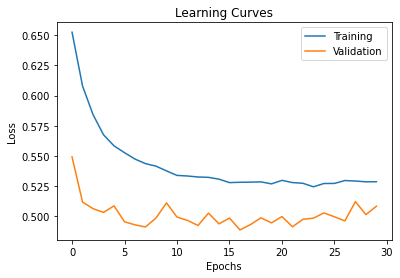

In [144]:
la.learning_curves()

Test Loss: 0.512 | Test Acc: 74.06%
              precision    recall  f1-score   support

         0.0       0.70      0.84      0.77      2513
         1.0       0.80      0.64      0.71      2473

    accuracy                           0.74      4986
   macro avg       0.75      0.74      0.74      4986
weighted avg       0.75      0.74      0.74      4986



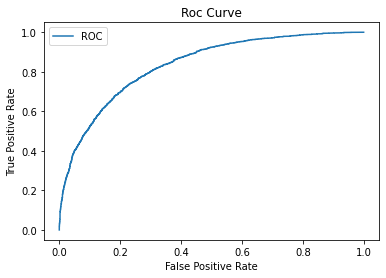

In [145]:
test_loss, test_acc, sc = Neural.evaluate(test_iterator, plot = True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

sc.report()
sc.plot_roc()

#### Experiment Documentation

As before, we will document every experiment we tried to increase performance (accuracy) and fitting. This time, we will only use a handful of 100k train_size experiments as well as a full dataset experiment

| TRAIN SIZE | EPOCHS |  N_LAYERS | EMBEDDING_DIM | HIDDEN_DIM | BIDIRECTIONAL | LEARNING_RATE | DROPOUT | CLIP VALUE | TIME PER EPOCH | FINAL TRAIN LOSS |ACCURACY | LEARNING CONCLUSION
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 100k | 30 | 2 | 50 | 256 | TRUE | 1e-5 | 0.8 | 1 | 12s | 0.446 | **77%** | **OK Fit** |
| 100k | 30 | 2 | 50 | 512 | TRUE | 1e-5 | 0.8 | 1 | 15s | 0.462 | **77%** | **Good Fit** |
| 100k | 30 | 3 | 50 | 512 | TRUE | 1e-5 | 0.8 | 1 | 24s | 0.496 | **76%** | **Good Fit** |
| 100k | 30 | 2 | 50 | 512 | TRUE | 1e-3 | 0.8 | 0.5 | 15s | 0.461 | **77%** | **Good Fit** |
| 100k | 30 | 2 | 50 | 512 | TRUE | 1e-5 | 0.8 | 3 | 15s |  0.461 | **77%** | **Good Fit** |
| 100k | 30 | 2 | 50 | 512 | TRUE | 1e-5 | 0.8 | 10 | 15s |  0.462 | **77%** | **Good Fit** |
| 100k | 30 | 2 | 50 | 512 | TRUE | 1e-5 | 0.8 | 0.1 | 15s |  0.460 | **77%** | **Good Fit** |
| 100k | 30 | 4 | 50 | 512 | TRUE | 1e-5 | 0.8 | 1 | 33s |  0.508 | **74%** | **Good Fit** |

Sadly but not entirely unexpectedly we don't see much of a difference using this technique. Not entirely unexpectedly, because our model is already fairing quite well in predicting sentiment. As we saw in the previous assignments we didn't get too far over the 75% benchmark in both of them. A thing that probably causes this behaviour, is the simple fact that we are not actually dealing with exploding gradients. Hence, we don't see a difference in performance. This can be seen by the diminishing performance as we complexify the problem, just as we saw in the previous section of experiments without the gradient clipping.

So, we can safely assume that exploding gradients is not the problem in our case. Maybe it is vanishing gradients. A problem which can be solved with the skip connections technique.

In any case we should test with the whole dataset.

## Conclusions and Comparison to the Previous Assignments

The recurrent neural network structure is certainly more fit to predict sentiment than the simple feed forward structure, especially in the way we built it. The fact, that in our case, context is being "remembered" by the network in order to figure out whether a text is positive or negative plays a big role in our previous statement. Now as we have discussed in the lectures and forums, it seems like that 75-80% accuracy is a benchmark that will only be beaten by excessive hyperparameter tuning, given our specific implementation of preprocessing, and general neural network structure.

Nevertheless, this assignment succeeds in creating a more fit neural network to predict twitter sentiments. In the previous assignment, we struggled to beat the 70% mark and only got to 74% as we made the network more complex and used better suited pre-trained embeddings.

This time we managed to reach upwards of 79% accuracy! Same as the first assignment we did, with simple logistic regression. I certainly did not expect the regression model to be the best model to solve this problem, but then again, I onnly scratched the surface of what is deep neural networks.

More specifically, the results we have gathered in this assignment are expected. GRUs outperform LSTMs in effiency and speed but LSTMs perform better on big data and more complex models. It seems like context plays a big role in our problem. That's one other reason that LSTMs slightly outperform the GRU approach.

We didn't get to see Gradient Clipping in action, probably because the problems it solves, namely exploding gradients, evidently, were not prevalent in our case. Sadly, we didn't get to experiment with other techniques like Stop Connections to combat the vanishing gradient problem if it existed, due to the contraints of time mostly.

We can clearly see how the more complex a model gets in structure, implementation or ability to be customized, a.k.a amount of tunable hyperparameters, the more time it takes for the model to train. In the previous assignments we could have our models train for thousands of epochs, without waiting for too long, while now even 10 epochs can take upwards of 2-3 hours.
That of course does not pose a problem, as the similar results in performance can be achieved with way less iterations.

## Citations

These are the sources and literature I used in the development.

1. [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) bt Andrej Karpathy
2. [Pytorch Sentiment Analysis](https://github.com/bentrevett/pytorch-sentiment-analysis) by Ben Trevett  
    Specifically:
    1. [Using TorchText with Your Own Datasets](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/A%20-%20Using%20TorchText%20with%20Your%20Own%20Datasets.ipynb)
    2. [Updated Sentiment Analysis](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb)

3. [Gradient Clipping](https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch)